In [9]:
from google.colab import drive
drive.mount('/content/drive')
# % cd drive/My Drive/hw3/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import dataset
import ranking as rnk
import evaluate as evl
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import stats
from torch.utils.data import Dataset, TensorDataset, DataLoader
import itertools

import math
data = dataset.get_dataset().get_data_folds()[0]
data.read_data()

In [0]:

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
#torch.manual_seed(0)

class RankNet(torch.nn.Module):
    def __init__(self, n_feature, n_hidden):
        super(RankNet, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.output = torch.nn.Linear(n_hidden, 1)      
        
    def forward(self, x1):
        x = torch.nn.functional.relu(self.hidden(x1))
        x = self.output(x)
        
        return x

class Model():
    def __init__(self, n_feature, n_hidden, learning_rate, sigma):
        self.ranknet = RankNet(n_feature, n_hidden)
        #.to(device)
        self.optimizer = torch.optim.SGD(self.ranknet.parameters(), lr=learning_rate)

def eval_model(model, data_fold):
    #with torch.no_grad():
        x = torch.from_numpy(data_fold.feature_matrix).float()
        y = data_fold.label_vector
        model.ranknet.eval()
               
        output = model.ranknet(x)
        output = output.detach().cpu().numpy().squeeze()
        
        #loss = torch.FloatTensor([0.5])*(torch.FloatTensor([1])-y)*((si-sj).sigmoid()).view(si.size(0))+torch.log(torch.FloatTensor([1])+torch.exp(-((si-sj).sigmoid().view(si.size(0)))))
        scores = evl.evaluate(data_fold, np.asarray(output))  

        return scores


def load_dataset():
    # data = dataset.get_dataset().get_data_folds()[0]
    # data.read_data()

    train_x = torch.from_numpy(data.train.feature_matrix).float()
    train_y = torch.from_numpy(data.train.label_vector).float()

    # documents = data.train.feature_matrix
    # doc_list = list(range(len(documents)))
    
    # # Carthesian product
    # Carth = list(itertools.combinations(doc_list,2))
    # x1, x2, target = [], [], []
  
    # # iterate over all possible combinations
    # for i,j in Carth:
    #     x1.append(docs[i])
    #     x2.append(docs[j])
    #     if data.train.label_vector[i]>data.train.label_vector[j]:
    #         # this is the S_{ij}
    #         target.append(float(1))
    #     elif data.train.label_vector[i]<data.train.label_vector[j]:
    #         target.append(float(-1))
    #     else:
    #         target.append(float(0))


    train_set = TensorDataset(train_x, train_y)
    train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
#     return torch.FloatTensor(x1), torch.FloatTensor(x2), torch.FloatTensor(target)
    #return data
    return train_loader
       

def plot_ndcg_loss(ndcgs):
    x = np.arange(len(ndcgs))
    fig, ax = plt.subplots()
    
    ax.plot(x, ndcgs, label='NDCG')
    ax.set_xlabel("Batch % 2000")
    ax.set_ylabel("Score")
    ax.set_title("Pointwise LTR")
    legend = ax.legend(loc='upper center')
    
    plt.show()
    plt.savefig('Pairwise_LTR_plot.png')

    
def train_batch(documentfeatures, labels, model, sig):
#     model.ranknet.train()
    for epoch in range(1):
#         for qid in range(0, train_data.num_queries()):
#             if train_data.query_size(qid) < 2:
#                 continue
 
            model.optimizer.zero_grad()

            output = model.ranknet(documentfeatures)
            
            loss = pairwiseloss(output, labels, sig)
        
            loss.backward()
            
            model.optimizer.step()
            
    return model
    
def pairwiseloss(predictedvals, values, sig):
    
    predictedvals = predictedvals.squeeze()

    # Hier is waar er is gesleuteld aan de data om de nan's te voorkomen
    if predictedvals.shape[0] == 0:
        return torch.tensor([0.0], requires_grad= True)
    # pairs = int(math.factorial(n_docs) / (math.factorial(n_docs - 2) * 2))
    tups = list(itertools.combinations(range(predictedvals.shape[0]), 2))
    

    val1, val2 = [x[0] for x in tups], [x[1] for x in tups]
    #todevice
    pred1 = predictedvals[val1]
    pred2 = predictedvals[val2]
    
    true1 = values[val1]
    true2 = values[val2]
    #.todevice
    s1 = (true1 > true2).type(torch.FloatTensor)
    s2 = (true1 < true2).type(torch.FloatTensor)
    
    S =  s1 - s2
    S = torch.tensor(S)
    sigma = sig
    C_T = (0.5 * (1 - S) * sigma * (pred1-pred2) + torch.log(1 + torch.exp(-sigma*(pred1-pred2))))
    C_T = torch.tensor(C_T, requires_grad = True)
    

    return C_T.mean()

def hyperparam_search():
    # hyper-parameters
    epochs = 10
    learning_rates = [10**-1, 10**-2, 10**-3, 10**-4]
    n_hiddens = [100, 150, 200, 250, 300, 350, 400]
#     learning_rates = [ 10**-1]
#     n_hiddens = [150, 200, 250]
    sig = [0.1, 1, 10, 100]
    print("hi")
#     train_loader = load_dataset()
    print("2")
    best_ndcg = 0
    for learning_rate in learning_rates:
        for n_hidden in n_hiddens:
            for sigma in sig:

                print("\nTesting learning_rate = {}, n_hidden = {} and sigma = {}".format(learning_rate, n_hidden, sigma))
                model = Model(data.num_features, n_hidden, learning_rate, sigma)

                last_ndcg = 0
                for epoch in range(epochs):

                    model.ranknet.train()
                    for qid in range(0, data.train.num_queries()):#
                        if data.train.query_size(qid) < 2:#
                            continue#
                        s_i, e_i = data.train.query_range(qid)

                        documentfeatures = torch.tensor(data.train.feature_matrix[s_i:e_i]).float()
                        labels = torch.tensor(data.train.label_vector[s_i:e_i])
    #                     if documentfeatures.shape[0] == 0:
    #                         return torch.tensor([0.0], requires_grad= True)

                        model = train_batch(documentfeatures, labels, model, sigma)  

                                       
                    scores = eval_model(model, data.validation)
              
                    ndcg = scores["ndcg"][0]
                    print("Epoch: {}, ndcg: {}".format(epoch, ndcg))
                            
                    if ndcg < last_ndcg:
                        break
                    last_ndcg = ndcg
                    if ndcg > best_ndcg:
                        best_ndcg = ndcg
                        best_params = {"learning_rate": learning_rate, "n_hidden": n_hidden, "epoch": epoch, "sigma": sigma}            
                        print("Best parameters:", best_params)
    
    return best_params

# hyperparam_search()



#### Loss functie 1tje kiezen voor validation en train.
####  

# {'learning_rate': 0.1, 'n_hidden': 100, 'epoch': 8}
# {'learning_rate': 0.1, 'n_hidden': 250, 'epoch': 6}

In [0]:

def train_best(best_params):
    epochs = best_params["epoch"]
    n_hidden = best_params["n_hidden"]
    learning_rate = best_params["learning_rate"]
    sigma = best_params["sigma"]
    
    # load data
#     data, train_loader = load_dataset()
    model = Model(data.num_features, n_hidden, learning_rate, sigma)

    losses, ndcgs = [], []
    for epoch in range(epochs):
        eval_count = 0
        for qid in range(0, data.train.num_queries()):#
            if data.train.query_size(qid) < 2:#
                continue#
            s_i, e_i = data.train.query_range(qid)
            
            documentfeatures = torch.tensor(data.train.feature_matrix[s_i:e_i]).float()
            labels = torch.tensor(data.train.label_vector[s_i:e_i])
            model = train_batch(documentfeatures, labels, model, sigma) 
            eval_count +=1
            if eval_count % 2000 == 0:
                scores = eval_model(model, data.validation)
                ndcgs.append(scores["ndcg"][0])
        print("Epoch: {}, ndcg: {}".format(epoch, scores["ndcg"][0]))
        
    return ndcgs, model

hi
2

Testing learning_rate = 0.1, n_hidden = 100 and sigma = 0.1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


"metric": "mean" ("standard deviation")
Epoch: 0, ndcg: 0.7254304373723682
Best parameters: {'learning_rate': 0.1, 'n_hidden': 100, 'epoch': 0, 'sigma': 0.1}
"metric": "mean" ("standard deviation")
Epoch: 1, ndcg: 0.7256076200855712
Best parameters: {'learning_rate': 0.1, 'n_hidden': 100, 'epoch': 1, 'sigma': 0.1}
"metric": "mean" ("standard deviation")
Epoch: 2, ndcg: 0.7255075943152488

Testing learning_rate = 0.1, n_hidden = 100 and sigma = 1
"metric": "mean" ("standard deviation")
Epoch: 0, ndcg: 0.6947550850784654
"metric": "mean" ("standard deviation")
Epoch: 1, ndcg: 0.6947602991265015
"metric": "mean" ("standard deviation")
Epoch: 2, ndcg: 0.6947859746863303
"metric": "mean" ("standard deviation")
Epoch: 3, ndcg: 0.6948038542738088
"metric": "mean" ("standard deviation")
Epoch: 4, ndcg: 0.6947796343069744

Testing learning_rate = 0.1, n_hidden = 100 and sigma = 10
"metric": "mean" ("standard deviation")
Epoch: 0, ndcg: 0.7162216869439334
"metric": "mean" ("standard deviation")


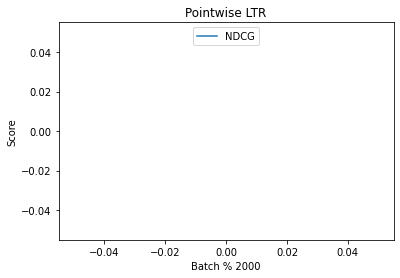

"metric": "mean" ("standard deviation")


<Figure size 432x288 with 0 Axes>

In [13]:

# def train_best(best_params):
#     epochs = best_params["epoch"]
#     n_hidden = best_params["n_hidden"]
#     learning_rate = best_params["learning_rate"]
    
#     # load data
#     data, train_loader = load_dataset()
#     model = Model(data.num_features, n_hidden, learning_rate)

#     losses, ndcgs = [], []
#     for epoch in range(epochs):
#         eval_count = 0
#         for x_batch, y_batch in train_loader:
#             model = train_batch(x_batch, y_batch, model)
#             eval_count +=1
#             if eval_count % 2000 == 0:
#                 loss, scores = eval_model(model, data.validation)
#                 losses.append(loss)
#                 ndcgs.append(scores["ndcg"][0])
#         print("Epoch: {}, ndcg: {}".format(epoch, scores["ndcg"][0]))
        
#     return ndcgs, losses, model


def get_distributions(model):
    data = dataset.get_dataset().get_data_folds()[0]
    data.read_data()
    model.ranknet.eval()

    val_x = torch.from_numpy(data.validation.feature_matrix).float()
    test_x = torch.from_numpy(data.test.feature_matrix).float()
           
    val = model.ranknet(val_x).detach().cpu().numpy().squeeze()
    test = model.ranknet(test_x).detach().cpu().numpy().squeeze()
    actual = np.concatenate((data.train.label_vector, data.validation.label_vector, data.test.label_vector))
    
    distributions = {
    "val_mean": np.mean(val),
    "val_std": np.std(val),
    "test_mean": np.mean(test),
    "test_std": np.std(test),
    "actual_mean": np.mean(actual), 
    "actual_std": np.std(actual),
    }
    
    return distributions



if __name__ == "__main__":
    #determine best hyper parameters
    best_params = hyperparam_search()
    #train best model
    ndcgs, model = train_best(best_params)
    #plot ndcg and loss    
    plot_ndcg_loss(ndcgs)
    #get distributions of scores
    distributions = get_distributions(model)
    #performance on test set
    data = dataset.get_dataset().get_data_folds()[0]
    data.read_data()
    scores = eval_model(model, data.test)



In [0]:

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
#torch.manual_seed(0)

class RankNetSU(torch.nn.Module):
    def __init__(self, n_feature, n_hidden):
        super(RankNetSU, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.output = torch.nn.Linear(n_hidden, 1)      
        
    def forward(self, x1):
        x = torch.nn.functional.relu(self.hidden(x1))
        x = self.output(x)
        
        return x

class Model():
    def __init__(self, n_feature, n_hidden, learning_rate, sigma):
        self.ranknet = RankNetSU(n_feature, n_hidden)
        #.to(device)
        self.optimizer = torch.optim.SGD(self.ranknet.parameters(), lr=learning_rate)

def eval_model(model, data_fold):
    #with torch.no_grad():
        x = torch.from_numpy(data_fold.feature_matrix).float()
        y = data_fold.label_vector
        model.ranknet.eval()
               
        output = model.ranknet(x)
        output = output.detach().cpu().numpy().squeeze()
        
        #loss = torch.FloatTensor([0.5])*(torch.FloatTensor([1])-y)*((si-sj).sigmoid()).view(si.size(0))+torch.log(torch.FloatTensor([1])+torch.exp(-((si-sj).sigmoid().view(si.size(0)))))
        scores = evl.evaluate(data_fold, np.asarray(output))  

        return scores


def load_dataset():

    train_x = torch.from_numpy(data.train.feature_matrix).float()
    train_y = torch.from_numpy(data.train.label_vector).float()

    train_set = TensorDataset(train_x, train_y)
    train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)

    return train_loader
       

def plot_ndcg_loss(losses, ndcgs):
    x = np.arange(len(losses))
    fig, ax = plt.subplots()
    
    ax.plot(x, losses, label='Loss')
    ax.plot(x, ndcgs, label='NDCG')
    ax.set_xlabel("Batch % 2000")
    ax.set_ylabel("Score")
    ax.set_title("Pointwise LTR")
    legend = ax.legend(loc='upper center')
    
    plt.show()
    plt.savefig('Pairwise_LTR_plot.png')

    
def train_batch(documentfeatures, labels, model, sig):
#     model.ranknet.train()
    for epoch in range(1):
#         for qid in range(0, train_data.num_queries()):
#             if train_data.query_size(qid) < 2:
#                 continue
            model.optimizer.zero_grad()

            output = model.ranknet(documentfeatures)
            
            loss = pairwiseloss(output, labels, sig)
            
            # AttributeError: 'Tensor' object has no attribute 'forward'
            
            loss.sum().backward()
            
            model.optimizer.step()

    return model
    
def pairwiseloss(predictedvals, values, sig):
    
    predictedvals = predictedvals.squeeze()

    if predictedvals.shape[0] == 0:
        return torch.tensor([0.0], requires_grad= True)
    tups = list(itertools.combinations(range(predictedvals.shape[0]), 2))
#     print(tups)
    val1, val2 = [x[0] for x in tups], [x[1] for x in tups]
    #todevice
    pred1 = predictedvals[val1]
    pred2 = predictedvals[val2]
    
    true1 = values[val1]
    true2 = values[val2]
    #.todevice
    s1 = (true1 > true2).type(torch.FloatTensor)
    s2 = (true1 < true2).type(torch.FloatTensor)
    
    S =  s1 - s2
    S = torch.tensor(S)
#     print(S)
#     print(s1)
#     print(s2)
    sigma = sig
#     print(val1)
    
    lambda_ij = sig*(torch.FloatTensor([0.5])*(torch.FloatTensor([1])-S)-(torch.FloatTensor([1])/(torch.FloatTensor([1])+torch.exp((pred1-pred2)*sigma))))
#     print(lambda_ij.shape)
#     lambda_ij = torch.sigmoid(torch.FloatTensor([0.5])*(torch.FloatTensor([1])-S)torch.log(torch.FloatTensor([1])+torch.exp(-((s_i-s_j).sigmoid().view(s_i.size(0)))))
#     print(predictedvals.shape)
    lambda_i = np.zeros(len(set(val1))+1)
    n=0
    for i in val1:
        lambda_i[i]+= lambda_ij[n]
        n += 1
#     print(val2)
    m = 0
    for j in val2:
        lambda_i[j]-= lambda_ij[m] 
        m += 1
    lambda_i = torch.tensor(lambda_i, requires_grad=True)
#     print(lambda_i)
#     print(lambda_i.shape)
    return predictedvals * lambda_i.detach()

def hyperparam_search():
    # hyper-parameters
    epochs = 2
    learning_rates = [10**-1, 10**-2, 10**-3, 10**-4]
    n_hiddens = [100, 150, 200, 250, 300, 350, 400]
    sigma = [-1, 1, 10, 60, 100]
    # learning_rates = [10**-2]
    # n_hiddens = [100]
    # sigma = [1]
    print("hi")
#     train_loader = load_dataset()
    print("2")
    best_ndcg = 0
    for learning_rate in learning_rates:
        for n_hidden in n_hiddens:
            for sig in sigma:
        
                print("\nTesting learning_rate = {} and n_hidden = {}".format(learning_rate, n_hidden))
                model = Model(data.num_features, n_hidden, learning_rate, sig)

                last_ndcg = 0
                for epoch in range(epochs):

                    model.ranknet.train()
                    for qid in range(0, data.train.num_queries()):#
                        if data.train.query_size(qid) < 2:#
                            continue#
                        s_i, e_i = data.train.query_range(qid)

                        documentfeatures = torch.tensor(data.train.feature_matrix[s_i:e_i]).float()
                        labels = torch.tensor(data.train.label_vector[s_i:e_i])
    #                     if documentfeatures.shape[0] == 0:
    #                         return torch.tensor([0.0], requires_grad= True)

                        model = train_batch(documentfeatures, labels, model, sig)  


                    scores = eval_model(model, data.validation)

                    ndcg = scores["ndcg"][0]
                    print("Epoch: {}, ndcg: {}".format(epoch, ndcg))

                    if ndcg < last_ndcg:
                        break
                    last_ndcg = ndcg
                    if ndcg > best_ndcg:
                        best_ndcg = ndcg
                        best_params = {"learning_rate": learning_rate, "n_hidden": n_hidden, "epoch": epoch, "sigma": sig}            
                        print("Best parameters:", best_params)
    
    return best_params

# hyperparam_search()


#### Loss functie 1tje kiezen voor validation en train.
####  

# {'learning_rate': 0.1, 'n_hidden': 100, 'epoch': 8}
def train_best(best_params):
    epochs = best_params["epoch"]
    n_hidden = best_params["n_hidden"]
    learning_rate = best_params["learning_rate"]
    sigma = best_params["sigma"]
    
    # load data
#     data, train_loader = load_dataset()
    model = Model(data.num_features, n_hidden, learning_rate, sigma)

    losses, ndcgs = [], []
    for epoch in range(epochs):
        eval_count = 0
        for qid in range(0, data.train.num_queries()):#
            if data.train.query_size(qid) < 2:#
                continue#
            s_i, e_i = data.train.query_range(qid)
            
            documentfeatures = torch.tensor(data.train.feature_matrix[s_i:e_i]).float()
            labels = torch.tensor(data.train.label_vector[s_i:e_i])
            model = train_batch(documentfeatures, labels, model, sigma) 
            eval_count +=1
            if eval_count % 2000 == 0:
                scores = eval_model(model, data.validation)
                ndcgs.append(scores["ndcg"][0])
        print("Epoch: {}, ndcg: {}".format(epoch, scores["ndcg"][0]))
        
    return ndcgs, model


def get_distributions(model):
    data = dataset.get_dataset().get_data_folds()[0]
    data.read_data()
    model.ranknet.eval()

    val_x = torch.from_numpy(data.validation.feature_matrix).float()
    test_x = torch.from_numpy(data.test.feature_matrix).float()
           
    val = model.ranknet(val_x).detach().cpu().numpy().squeeze()
    test = model.ranknet(test_x).detach().cpu().numpy().squeeze()
    actual = np.concatenate((data.train.label_vector, data.validation.label_vector, data.test.label_vector))
    
    distributions = {
    "val_mean": np.mean(val),
    "val_std": np.std(val),
    "test_mean": np.mean(test),
    "test_std": np.std(test),
    "actual_mean": np.mean(actual), 
    "actual_std": np.std(actual),
    }
    
    return distributions



if __name__ == "__main__":
    #determine best hyper parameters
    best_params = hyperparam_search()
    #train best model
    ndcgs, model = train_best(best_params)
    #plot ndcg and loss    
    plot_ndcg_loss(ndcgs)
    #get distributions of scores
    distributions = get_distributions(model)
    #performance on test set
    data = dataset.get_dataset().get_data_folds()[0]
    data.read_data()
    scores = eval_model(model, data.test)


hi
2

Testing learning_rate = 0.1 and n_hidden = 100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


"metric": "mean" ("standard deviation")
Epoch: 0, ndcg: 0.7190389939666768
Best parameters: {'learning_rate': 0.1, 'n_hidden': 100, 'epoch': 0, 'sigma': -1}
"metric": "mean" ("standard deviation")
Epoch: 1, ndcg: 0.7201143979826179
Best parameters: {'learning_rate': 0.1, 'n_hidden': 100, 'epoch': 1, 'sigma': -1}

Testing learning_rate = 0.1 and n_hidden = 100
"metric": "mean" ("standard deviation")
Epoch: 0, ndcg: 0.720002235871374
"metric": "mean" ("standard deviation")
Epoch: 1, ndcg: 0.7195722413730479

Testing learning_rate = 0.1 and n_hidden = 100
"metric": "mean" ("standard deviation")
Epoch: 0, ndcg: 0.7171255579091167
"metric": "mean" ("standard deviation")
Epoch: 1, ndcg: 0.7173110698553419

Testing learning_rate = 0.1 and n_hidden = 100
"metric": "mean" ("standard deviation")
Epoch: 0, ndcg: 0.717013554564625
"metric": "mean" ("standard deviation")
Epoch: 1, ndcg: 0.7193938019733462

Testing learning_rate = 0.1 and n_hidden = 100
"metric": "mean" ("standard deviation")
Epoch:

In [0]:
## Below is Rubens code altered to include a sigma instead of a sigmoid

In [0]:
import dataset
import ranking as rnk
import evaluate as evl
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import itertools

from scipy import stats
from torch.utils.data import Dataset, TensorDataset, DataLoader


# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.manual_seed(0)

data = dataset.get_dataset().get_data_folds()[0]
data.read_data()


class Model():
    def __init__(self, n_feature, n_hidden, learning_rate, sigma):
        self.net = nn.Sequential(
                                 nn.Linear(n_feature, n_hidden),
                                 nn.ReLU(),
                                 nn.Linear(n_hidden, 1)
                                )
        self.criterion = pair_loss
        self.optimizer = torch.optim.SGD(self.net.parameters(), lr=learning_rate)


def pair_loss(output, y, sigma):
    output = output.squeeze()
    
    if y.shape[0] == 1:
        return (output - y)**2

    pairs = list(itertools.combinations(range(output.shape[0]), 2))
    val1, val2 = [x[0] for x in pairs], [x[1] for x in pairs]

    # pred1 = output[val1].to(device)
    # pred2 = output[val2].to(device)
    pred1 = output[val1]
    pred2 = output[val2]

    true1 = y[val1]
    true2 = y[val2]

    # s1 = (true1 > true2).type(torch.ByteTensor).to(device)
    # s2 = (true1 < true2).type(torch.ByteTensor).to(device)
    s1 = (true1 > true2).type(torch.ByteTensor)
    s2 = (true1 < true2).type(torch.ByteTensor)

    S =  s1 - s2
    # sigmoid = torch.sigmoid(pred1.float() - pred2.float())
    
    C = (0.5 * (1 - S) * sigma + torch.log(1 + torch.exp(-sigma*(pred1-pred2))))
    
    return C.mean()     
    

def eval_model(model, data_fold):
    with torch.no_grad():
        x = torch.from_numpy(data_fold.feature_matrix).float()
        y = data_fold.label_vector
        model.net.eval()
               
        output = model.net(x)      
          
        output = output.detach().cpu().numpy().squeeze()
        
        scores = evl.evaluate(data_fold, np.asarray(output))  

    return scores

def calc_ERR(model, data_fold):
    ERR = 0
    for qid in range(data_fold.num_queries()):
                    
        s_i, e_i = data.train.query_range(qid)
        x = torch.from_numpy(data.train.feature_matrix[s_i:e_i]).float()
        y = torch.from_numpy(data.train.label_vector[s_i:e_i])
        
        output = model.net(x)
        
        

    
def train_batch(x_batch, y_batch, model, sigma):
    model.net.train()
    model.optimizer.zero_grad()
    # x_batch = x_batch.to(device)
    # y_batch = y_batch.to(device) 
    x_batch = x_batch
    y_batch = y_batch
           
    output = model.net(x_batch)
    loss = model.criterion(output, y_batch, sigma)
    
    loss.backward()
    model.optimizer.step()
    
    return model

       
def hyperparam_search():
    # hyper-parameters
    epochs = 300
    learning_rates = [10**-1, 10**-2, 10**-3, 10**-4]
    n_hiddens = [100, 150, 200, 250, 300, 350, 400]
    sigmas = [1, 10, 60, 100]

    
    best_ndcg = 0
    for learning_rate in learning_rates:
        for n_hidden in n_hiddens:
          for sigma in sigmas:
        
              print("\nTesting learning_rate = {}, n_hidden = {} and sigma = {}".format(learning_rate, n_hidden, sigma))
              model = Model(data.num_features, n_hidden, learning_rate, sigma)
              switch = False
              last_ndcg = 0
              for epoch in range(epochs):
                  
                  model.net.train()
                  for qid in range(data.train.num_queries()):
                      
                      s_i, e_i = data.train.query_range(qid)
                      x_batch = torch.from_numpy(data.train.feature_matrix[s_i:e_i]).float()
                      y_batch = torch.from_numpy(data.train.label_vector[s_i:e_i])

                      model = train_batch(x_batch, y_batch, model, sigma)  
                  
                  scores = eval_model(model, data.validation)                                    
                  ndcg = scores["ndcg"][0]
                              
                  if ndcg < last_ndcg:
                      if switch: break
                      switch = True
                  
                  last_ndcg = ndcg
                  if ndcg > best_ndcg:
                      best_ndcg = ndcg
                      best_params = {"learning_rate": learning_rate, "n_hidden": n_hidden, "epoch": epoch, "sigma": sigma}            
                      print("Best parameters:", best_params)
                  print("Epoch: {}, ndcg: {}".format(epoch, ndcg))
    
    return best_params
    
    
def train_best(best_params):
    epochs = best_params["epoch"]
    n_hidden = best_params["n_hidden"]
    learning_rate = best_params["learning_rate"]
    sigma = best_params["sigma"]
    
    model = Model(data.num_features, n_hidden, learning_rate, sigma)

    ndcgs = []
    for epoch in range(epochs):
        eval_count = 0
        for qid in range(data.train.num_queries()):
                    
            s_i, e_i = data.train.query_range(qid)
            x_batch = torch.from_numpy(data.train.feature_matrix[s_i:e_i]).float()
            y_batch = torch.from_numpy(data.train.label_vector[s_i:e_i])

            model = train_batch(x_batch, y_batch, model, sigma)
            
            eval_count +=1
            if eval_count % 100 == 0:
                scores = eval_model(model, data.validation)
                ndcgs.append(scores["ndcg"][0])
        
        print("Epoch: {}, ndcg: {}".format(epoch, scores["ndcg"][0]))
        
    return ndcgs, model
    

if __name__ == "__main__":
    #determine best hyper parameters
    best_params = hyperparam_search()
    #train best model
    ndcgs, losses, model = train_best(best_params)
    #performance on test set
    scores = eval_model(model, data.test)
    error = calc_err(model, data.test)